- [9.2.4 - Example: Therapeutic touch](#9.2.4---Example:-Therapeutic-touch)   
- [9.5.1 - Example: Baseball batting abilities by position (Subjects within categories)](#9.5.1---Example:-Baseball-batting-abilities-by-position)   

## Chapter 9 - Hierarchical Models

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from IPython.display import Image
from matplotlib import gridspec

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

### 9.2.4 - Example: Therapeutic touch

In [2]:
df = pd.read_csv('data/TherapeuticTouchData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
y    280 non-null int64
s    280 non-null object
dtypes: int64(1), object(1)
memory usage: 4.5+ KB


#### Figure 9.9

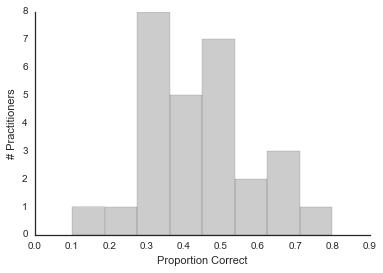

In [3]:
df_proportions = df.groupby('s')['y'].apply(lambda x: x.sum()/len(x))

ax = sns.distplot(df_proportions, bins=8, kde=False, color='gray')
ax.set(xlabel='Proportion Correct', ylabel='# Practitioners')
sns.despine(ax=ax);

#### Model (Kruschke, 2015)

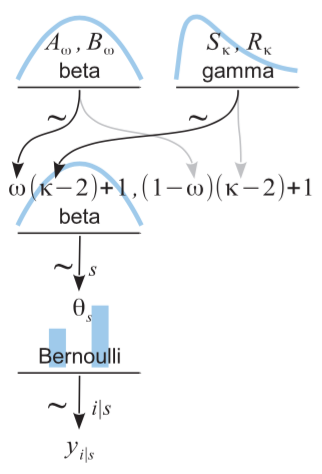

In [4]:
Image('images/fig9_7.png', width=250)

In [5]:
le = preprocessing.LabelEncoder()
practitioner_idx = le.fit_transform(df.s)

practitioner_codes = df.s.unique()
n_practitioners = len(practitioner_codes)

with pmc.Model() as hierarchical_model:
    omega = pmc.Beta('omega', 1, 1)
    kappa = pmc.Gamma('kappa', 0.01, 0.01)+2

    theta = pmc.Beta('theta', omega*(kappa-2)+1, (1-omega)*(kappa-2)+1, shape=n_practitioners)
    
    y = pmc.Bernoulli('y', theta[practitioner_idx], observed=df.y)    

Applied logodds-transform to omega and added transformed omega_logodds_ to model.
Applied log-transform to kappa and added transformed kappa_log_ to model.
Applied logodds-transform to theta and added transformed theta_logodds_ to model.


In [6]:
with hierarchical_model:
    start = pmc.find_MAP()
    step = pmc.NUTS(state=start)
        
    trace= pmc.sample(20000, step, start=start)

 [-----------------100%-----------------] 20000 of 20000 complete in 143.9 sec

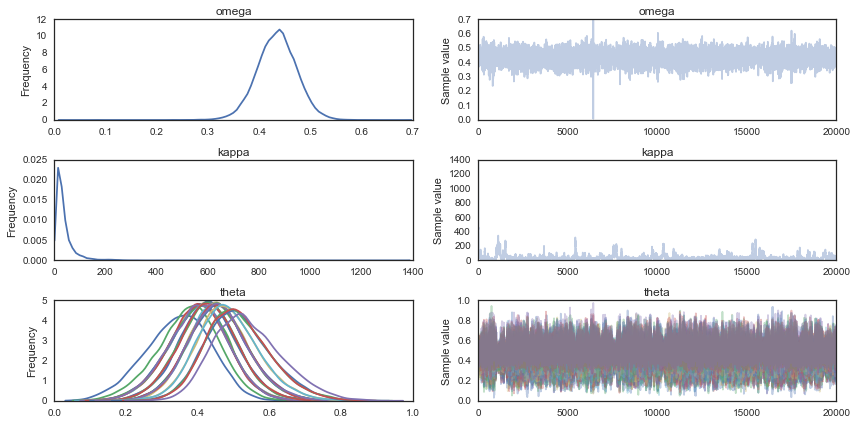

In [7]:
pmc.traceplot(trace);

In [8]:
pmc.df_summary(trace)

                mean         sd  mc_error   hpd_2.5    hpd_97.5
omega       0.434586   0.038940  0.000495  0.358587    0.509894
kappa      37.451444  43.643110  2.532721  2.275140  107.588163
theta__0    0.345026   0.091647  0.002570  0.160713    0.515748
theta__1    0.373869   0.087432  0.001824  0.192808    0.538613
theta__2    0.401476   0.085216  0.001186  0.225875    0.566291
theta__3    0.401743   0.085546  0.001156  0.226364    0.566603
theta__4    0.401991   0.085189  0.001219  0.227857    0.565029
theta__5    0.401984   0.085920  0.001108  0.226762    0.567353
theta__6    0.401345   0.085249  0.001204  0.231303    0.568804
theta__7    0.401946   0.085582  0.001206  0.225727    0.566435
theta__8    0.401073   0.084872  0.001154  0.223163    0.559916
theta__9    0.401427   0.085208  0.001075  0.233054    0.569107
theta__10   0.429084   0.085755  0.000618  0.262295    0.604616
theta__11   0.429016   0.083989  0.000634  0.263507    0.597241
theta__12   0.429198   0.084730  0.00065

#### Marginal posterior distributions

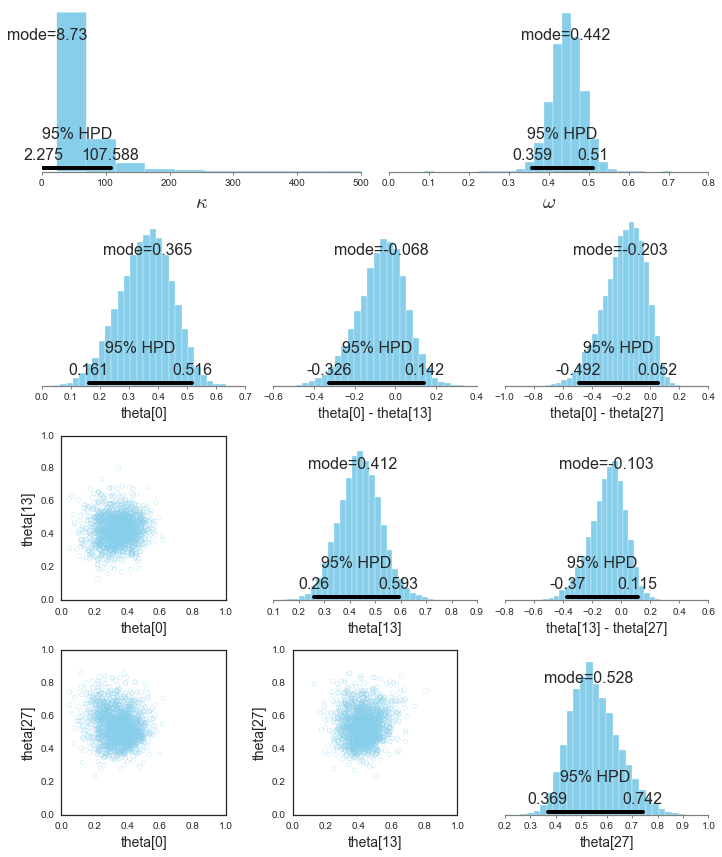

In [25]:
plt.figure(figsize=(10,12))

# Define gridspec
gs = gridspec.GridSpec(4, 6)
ax1 = plt.subplot(gs[0,:3])
ax2 = plt.subplot(gs[0,3:])
ax3 = plt.subplot(gs[1,:2])
ax4 = plt.subplot(gs[1,2:4])
ax5 = plt.subplot(gs[1,4:6])
ax6 = plt.subplot(gs[2,:2])                     
ax7 = plt.subplot(gs[2,2:4])
ax8 = plt.subplot(gs[2,4:6])
ax9 = plt.subplot(gs[3,:2])
ax10 = plt.subplot(gs[3,2:4])
ax11 = plt.subplot(gs[3,4:6])

font_d = {'size':14}
color = '#87ceeb'

# kappa posterior plot
pmc.plot_posterior(trace['kappa'], point_estimate='mode', ax=ax1, color=color)
ax1.set(xlim=(0,500))
ax1.set_xlabel('$\kappa$', fontdict={'size':20, 'weight':'bold'})

# omega posterior plot
pmc.plot_posterior(trace['omega'], point_estimate='mode', ax=ax2, color=color)
ax2.set_xlabel('$\omega$', fontdict={'size':20, 'weight':'bold'})

# theta posterior plots
pmc.plot_posterior(trace['theta'][:,0], point_estimate='mode', ax=ax3, color=color)
ax3.set_xlabel('theta[0]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,13], point_estimate='mode', ax=ax7, color=color)
ax7.set_xlabel('theta[13]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,27], point_estimate='mode', ax=ax11, color=color)
ax11.set_xlabel('theta[27]', fontdict=font_d)

# theta scatter plots
ax6.scatter(trace['theta'][::10,0], trace['theta'][::10,13], alpha=0.75, color=color, facecolor='none')
ax6.set_xlabel('theta[0]', fontdict=font_d)
ax6.set_ylabel('theta[13]', fontdict=font_d)

ax9.scatter(trace['theta'][::10,0], trace['theta'][::10,27], alpha=0.75, color=color, facecolor='none')
ax9.set_xlabel('theta[0]', fontdict=font_d)
ax9.set_ylabel('theta[27]', fontdict=font_d)

ax10.scatter(trace['theta'][::10,13], trace['theta'][::10,27], alpha=0.75, color=color, facecolor='none')
ax10.set_xlabel('theta[13]', fontdict=font_d)
ax10.set_ylabel('theta[27]', fontdict=font_d)

for ax in [ax6, ax9, ax10]:
    ax.set(xlim=(0,1), ylim=(0,1), aspect='equal') 
    
# theta posterior differences plots
pmc.plot_posterior(trace['theta'][:,0]-trace['theta'][:,14], point_estimate='mode', ax=ax4, color=color)
ax4.set_xlabel('theta[0] - theta[13]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,0]-trace['theta'][:,27], point_estimate='mode', ax=ax5, color=color)
ax5.set_xlabel('theta[0] - theta[27]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,13]-trace['theta'][:,27], point_estimate='mode', ax=ax8, color=color)
ax8.set_xlabel('theta[13] - theta[27]', fontdict=font_d)

plt.tight_layout();

### 9.5.1 - Example: Baseball batting abilities by position

In [10]:
df2 = pd.read_csv('data/BattingAverage.csv', usecols=[0,1,2,3])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
Player    948 non-null object
PriPos    948 non-null object
Hits      948 non-null int64
AtBats    948 non-null int64
dtypes: int64(2), object(2)
memory usage: 29.7+ KB


In [11]:
df2.head(10)

           Player      PriPos  Hits  AtBats
0   Fernando Abad     Pitcher     1       7
1     Bobby Abreu  Left Field    53     219
2      Tony Abreu    2nd Base    18      70
3   Dustin Ackley    2nd Base   137     607
4      Matt Adams    1st Base    21      86
5   Nathan Adcock     Pitcher     0       1
6  Jeremy Affeldt     Pitcher     0       1
7   Brandon Allen    1st Base     2      20
8   Yonder Alonso    1st Base   150     549
9     Jose Altuve    2nd Base   167     576

#### Model (Kruschke, 2015)

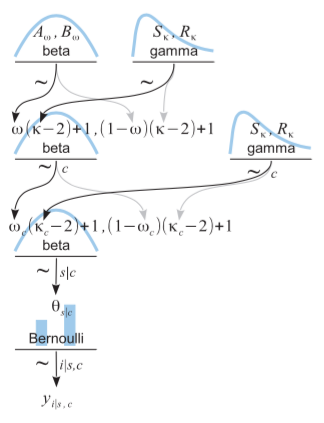

In [12]:
Image('images/fig9_13.png', width=400)